# Best ARIMA Model Selection

In this notebook, you will learn how to find the best fit ARIMA model using AIC score. The model selection and fitting are done in a rolling window fashion.

You will perform the following steps:

1. [Read the data](#read)<br>
1. [Forecast using the best fit model](#forecast)<br>
1. [Generate signals for the strategy](#signal)<br>
1. [Analyse the strategy performance](#analyse)<br>

<a id='read'></a> 
## Read the data

In [4]:
# Import the libraries

# Data manipulation
import numpy as np
import pandas as pd

# For statistical analysis
from statsmodels.tsa.arima_model import ARIMA

# For statistical analysis
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# read the file from the binance data (see the binance data notebook to get details on how to download the data)
path_file = 'C:/Users/Pastor/Dropbox/Pastor/data/binance_data_USDT/BTCUSDT.csv'
data = pd.read_csv(path_file, index_col = 0)
data.index = pd.to_datetime(df.index)

# drop missing values if any
data = data.dropna()

# To analyse strategy performance
import sys
sys.path.append("..")
from tsa_functions_quantra import analyse_strategy


# Rolling window
rolling_window = int(len(df)*0.70)

# print the last observations
data.tail()

,datetime,Open,High,Low,Close,Volume,adj_close
Date,,,,,,,
2021-10-12 20:00:00,1634083200000,55996.91,57777.00,54167.19,57367.00,55808.444920,57367.00
2021-10-13 20:00:00,1634169600000,57370.83,58532.54,56818.05,57347.94,43053.336781,57347.94
2021-10-14 20:00:00,1634256000000,57347.94,62933.00,56850.00,61672.42,82512.908022,61672.42
2021-10-15 20:00:00,1634342400000,61672.42,62378.42,60398.73,61060.84,23598.674360,61060.84
2021-10-15 20:00:00,1634342400000,61672.42,62378.42,60150.00,60751.88,34822.825310,60751.88


<a id='forecast'></a> 
# Forecast using the best fit model

The model selection and forecast is applied in a rolling window fashion.

In [5]:
# Setting the rolling window
rolling_window = int(len(data) * 0.70)

# Function to select the best model and forecast the price
def select_model_and_forecast(price_df):
    
    # The p,d and q values
    aic = []
    p = range(1, 3)
    d = range(0, 2)
    q = range(1, 3)

    # Empty list to store p,q,dist
    p_q_d = []

    # Get the aic score for different values of p, d and q
    for i in p:
        for j in d:
            for k in q:
                # Try to fit the model
                try:
                    gm = ARIMA(price_df, order=(i, j, k))
                    gm_fit = gm.fit(disp=0)
                    
                    # Calculate the AIC score
                    aic_temp = gm_fit.aic
                    keys_temp = (i, j, k)
                    
                    # Save the AIC score and the p, d and q values
                    p_q_d.append(keys_temp)
                    aic.append(aic_temp)
                except:
                    # Do nothing when the model does not fit
                    pass

    # Store values in dictionary
    aic_dict = {'p_q_d': p_q_d, 'aic': aic}

    # Create DataFrame from dictionary
    df = pd.DataFrame(aic_dict)

    # Get the minimum AIC value with the p,d and q values
    df = df[df['aic'] == df['aic'].min()].reset_index()

    # Only predict the price if the ARIMA model could be fit
    if len(df) > 0:
        # Fitting the optimum model
        gm = ARIMA(price_df, order=df.p_q_d[0])
        gm_fit = gm.fit(disp=0)
        
        # making the forecast
        predicted_price = gm_fit.forecast()[0][0]
        return predicted_price
    else:
        # Return -1 if the model could not be fit
        return -1

In [7]:
# Applying the `select_model_and_forecast` function to the price data
data['predicted'] = data['Close'].rolling(rolling_window).apply(select_model_and_forecast)

<a id='signal'></a> 
# Generate signals for the strategy

The asset is bought when the predicted price is greater than the close, and vice versa.



In [9]:
# Generate the signal
data['signal'] = np.where(data['predicted'] > data['Close'], 1, -1)

# Calculate strategy returns
data['strategy_returns'] = data['Close'].pct_change() * data['signal'].shift(1) 
# Drop the rows where there is NaN value
data.dropna(inplace=True)

<a id='analyse'></a> 
## Analyse the strategy performance


The Sharpe Ratio is -0.31
The cumulative return is -51.62%
The maximum drawdown is -82.80%


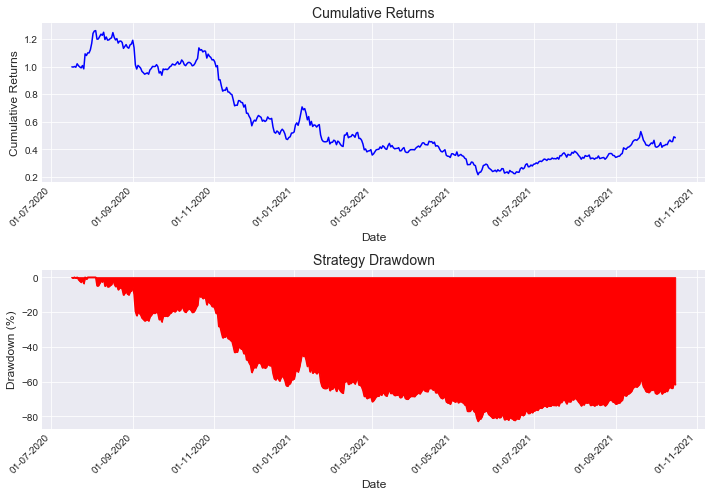

In [10]:
analyse_strategy(data['strategy_returns'])